#MSFT stock price forecast

## Part 0: Setup Google Drive Environment



In [ ]:
#import pandas as pd
#import numpy as np
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Importing libraries
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pylab import rcParams

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from tabulate import tabulate
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1wdf3FfKdR_xNh2rJeYWL4ye0_FUZ9WM7'


fluff, id = link.split('=')
file = drive.CreateFile({'id':id})
file.GetContentFile('MSFT_Stock.csv')
microsoft  = pd.read_csv('MSFT_Stock.csv', index_col='Date', parse_dates=['Date'])
Jack_TS_Monthly_df   = pd.read_csv('MSFT_Stock.csv')
microsoft.head()


,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [ ]:
import matplotlib.pyplot as plt
Jack_TS_df = microsoft


# Part 1: Data Exploration

#1.1 Understand the Raw Dataset

In [ ]:
Jack_TS_df.head()
Jack_TS_df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455
2021-03-30 16:00:00,233.53,233.85,231.10,231.85,24792012
2021-03-31 16:00:00,232.91,239.10,232.39,235.77,43623471


In [ ]:
# check data info
Jack_TS_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [ ]:
#check the unique values for each column
Jack_TS_df.nunique()

Open      1409
High      1400
Low       1397
Close     1398
Volume    1511
dtype: int64

In [ ]:
# check missing values
Jack_TS_df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

#1.2 EDA


---





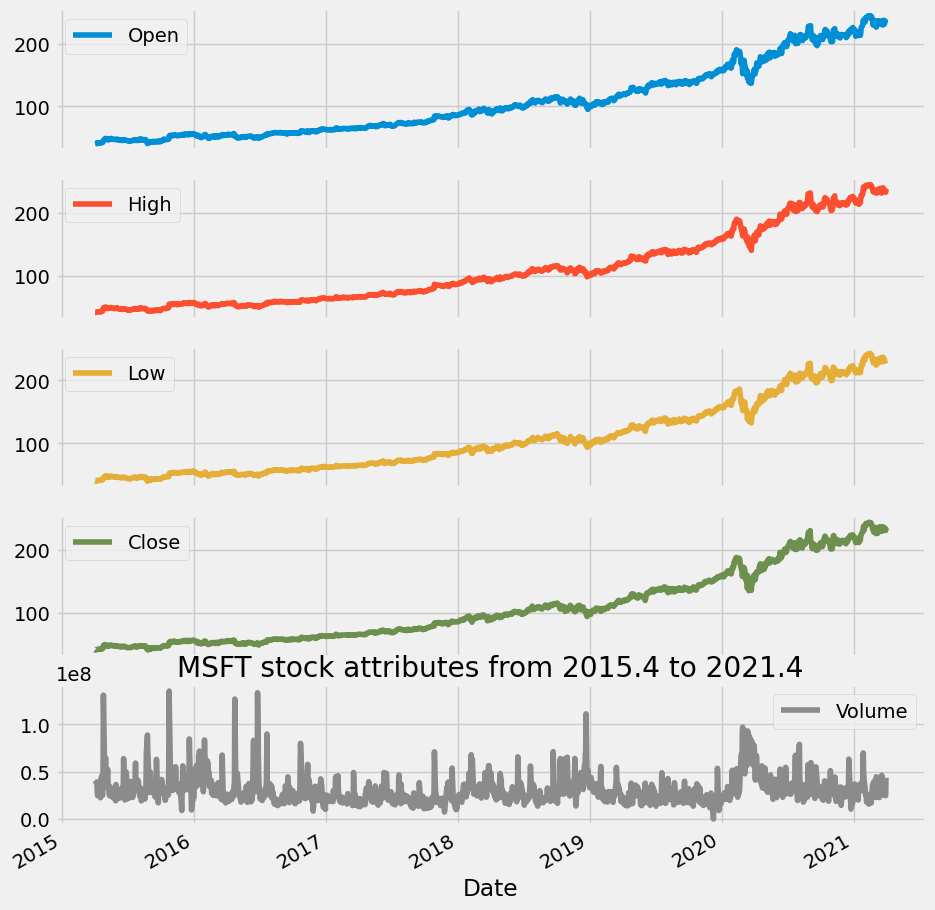

In [ ]:
Jack_TS_df['2015':'2021'].plot(subplots=True, figsize=(10,12))
plt.title('MSFT stock attributes from 2015.4 to 2021.4')
plt.savefig('stocks.png')

<Axes: xlabel='Date'>

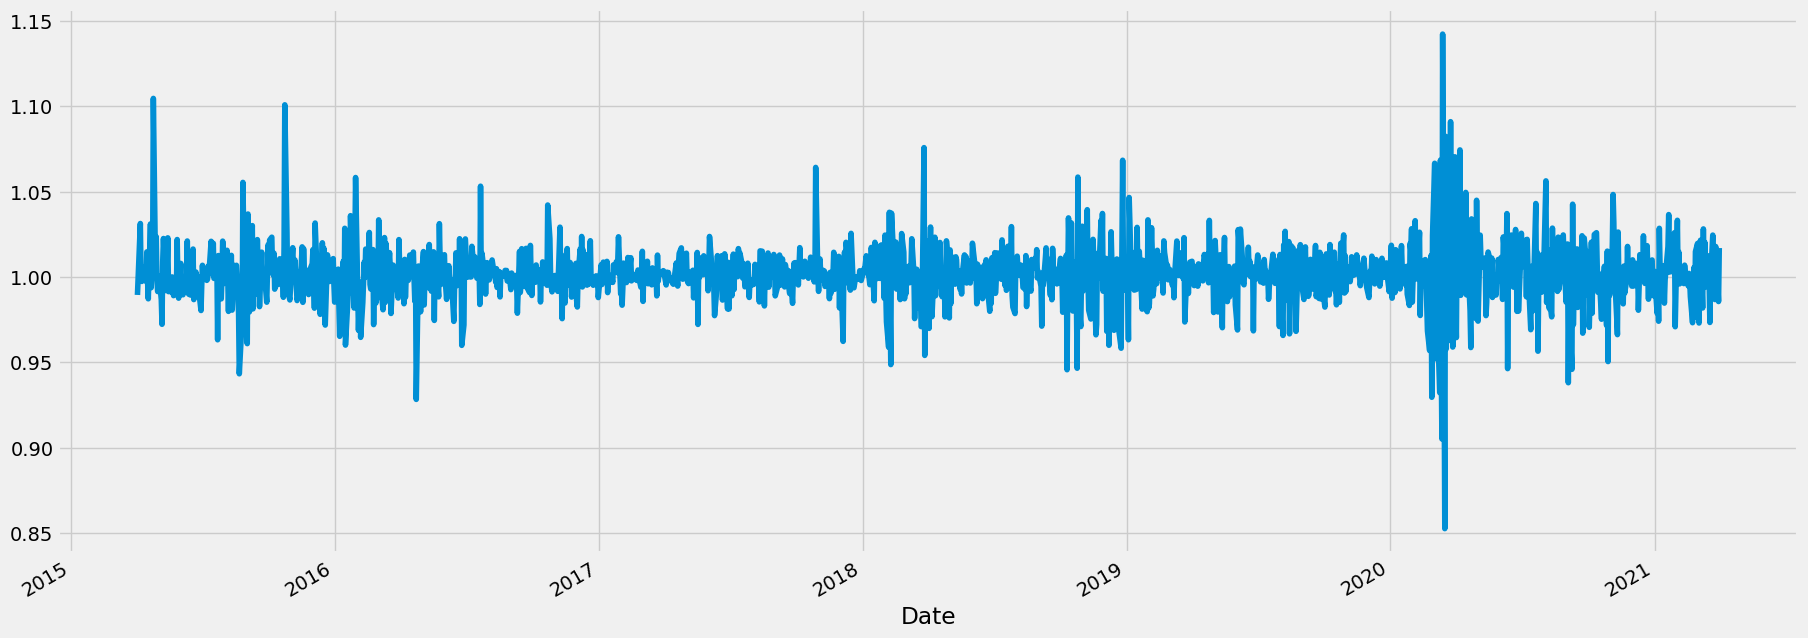

In [ ]:
Jack_TS_df['Change'] = Jack_TS_df.Close.div(Jack_TS_df.Close.shift())
Jack_TS_df['Change'].plot(figsize=(20,8))



<Axes: xlabel='Date'>

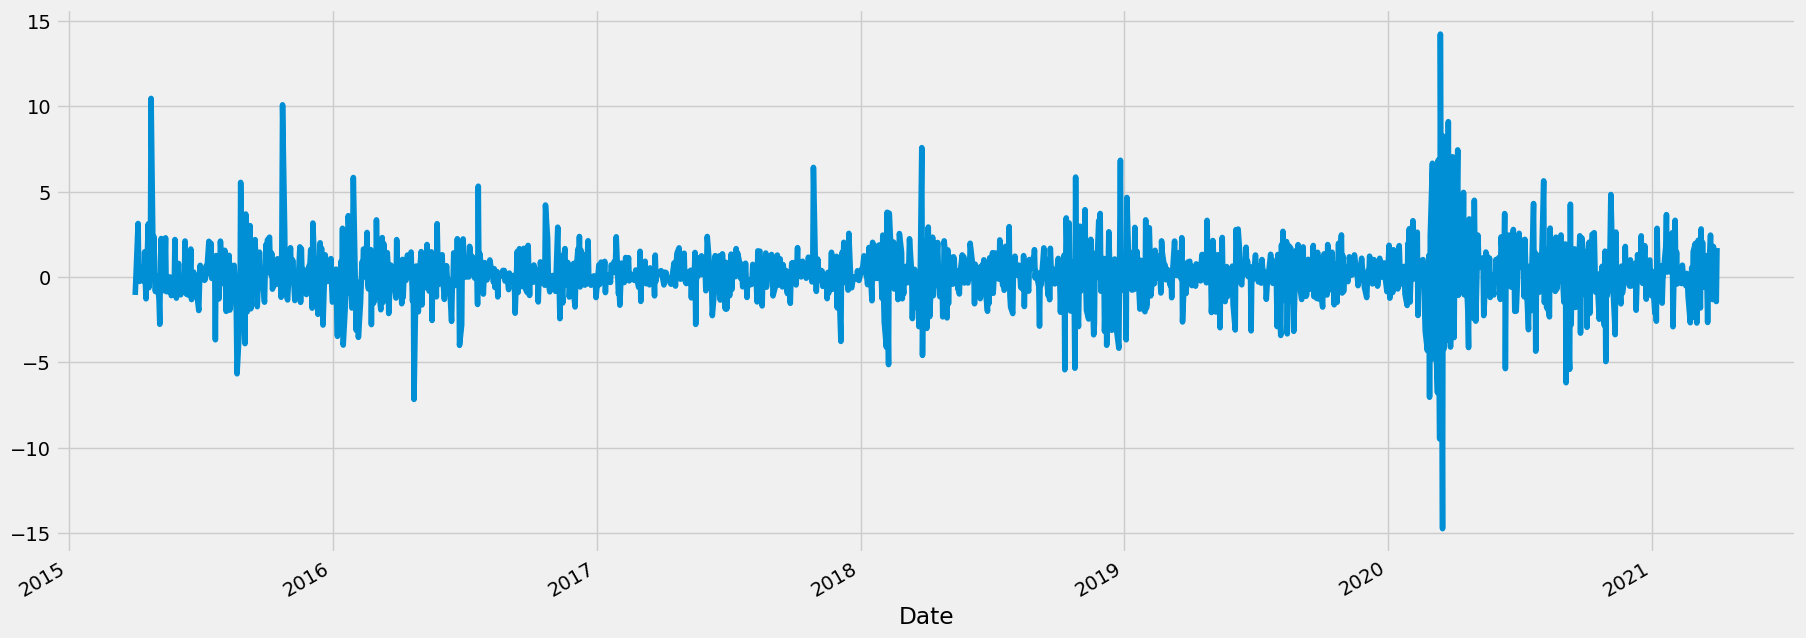

In [ ]:
Jack_TS_df['Return'] = Jack_TS_df.Change.sub(1).mul(100)
Jack_TS_df['Return'].plot(figsize=(20,8))

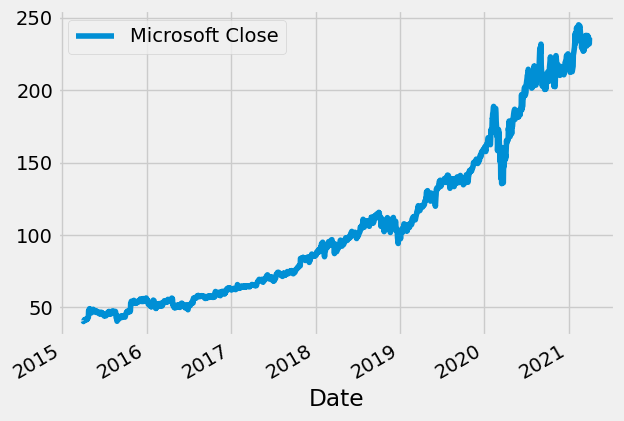

In [ ]:
Jack_TS_df.Close.plot()
plt.legend(['Microsoft Close'])

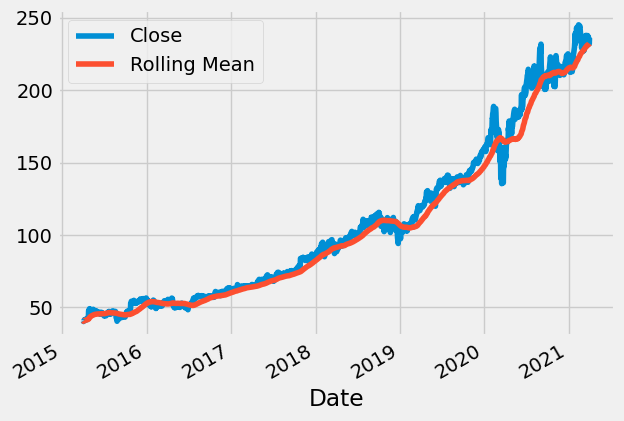

In [ ]:
rolling_MSFT = Jack_TS_df.Close.rolling('90D').mean()
Jack_TS_df.Close.plot()
rolling_MSFT.plot()

plt.legend(['Close','Rolling Mean'])

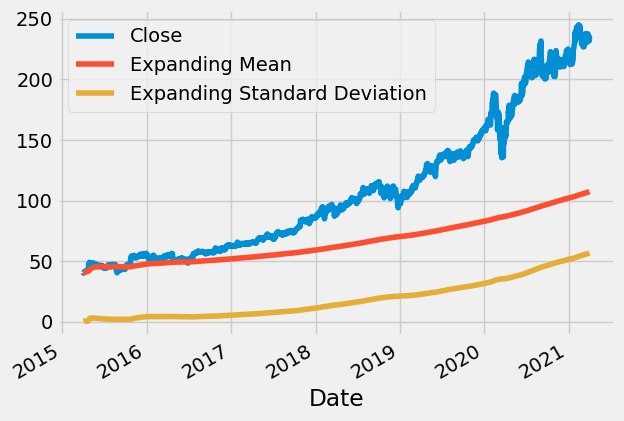

In [ ]:
microsoft_mean = Jack_TS_df.Close.expanding().mean()
microsoft_std = Jack_TS_df.Close.expanding().std()
Jack_TS_df.Close.plot()
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['Close','Expanding Mean','Expanding Standard Deviation'])

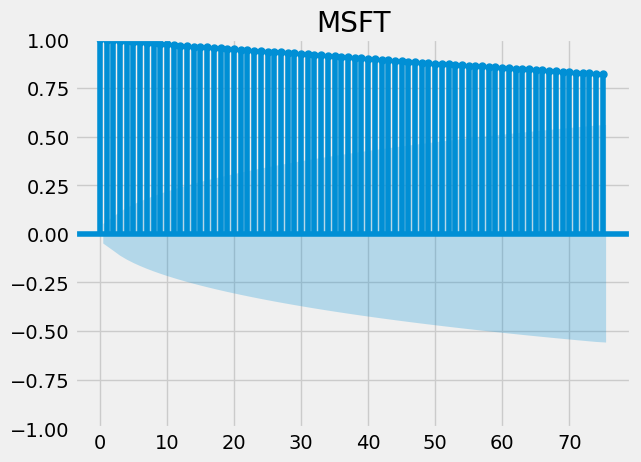

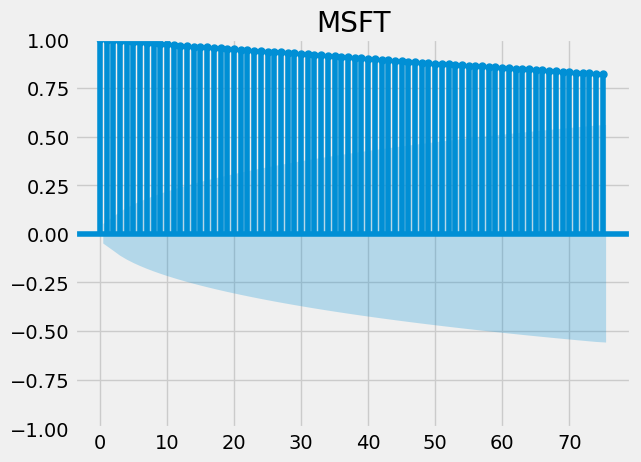

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(Jack_TS_df["Close"],lags=75,title="MSFT")

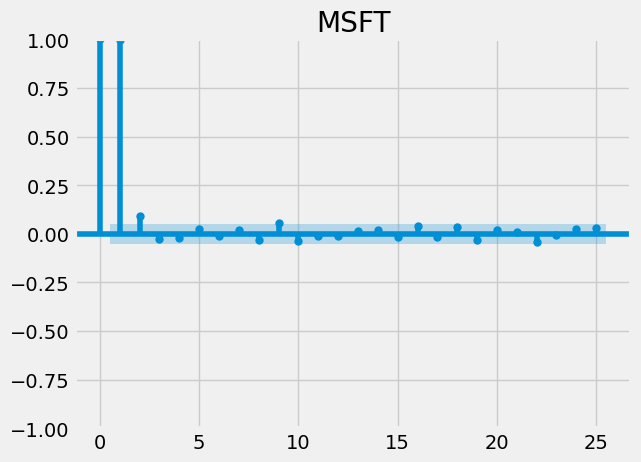

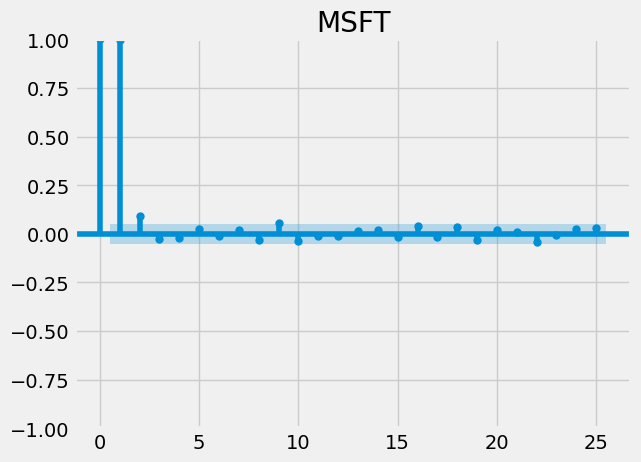

In [ ]:
plot_pacf(Jack_TS_df["Close"],lags=25,title="MSFT")

In [ ]:


Jack_TS_Monthly_df['dateN']=pd.to_datetime(Jack_TS_Monthly_df['Date'])

Jack_TS_Monthly_df.set_index('dateN',inplace=True)

Jack_TS_Monthly_df.head()

,Date,Open,High,Low,Close,Volume
dateN,,,,,,
2015-04-01 16:00:00,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


<Axes: xlabel='dateN'>

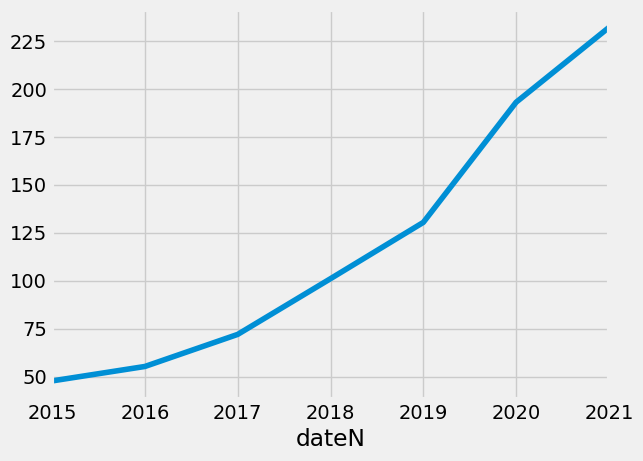

In [ ]:
Jack_TS_Monthly_df['Close'].resample('Y').mean().plot()

In [ ]:
Jack_TS_Monthly_df.describe()


,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


# Part 2: Data cleaning and feature analysis


## Data Description

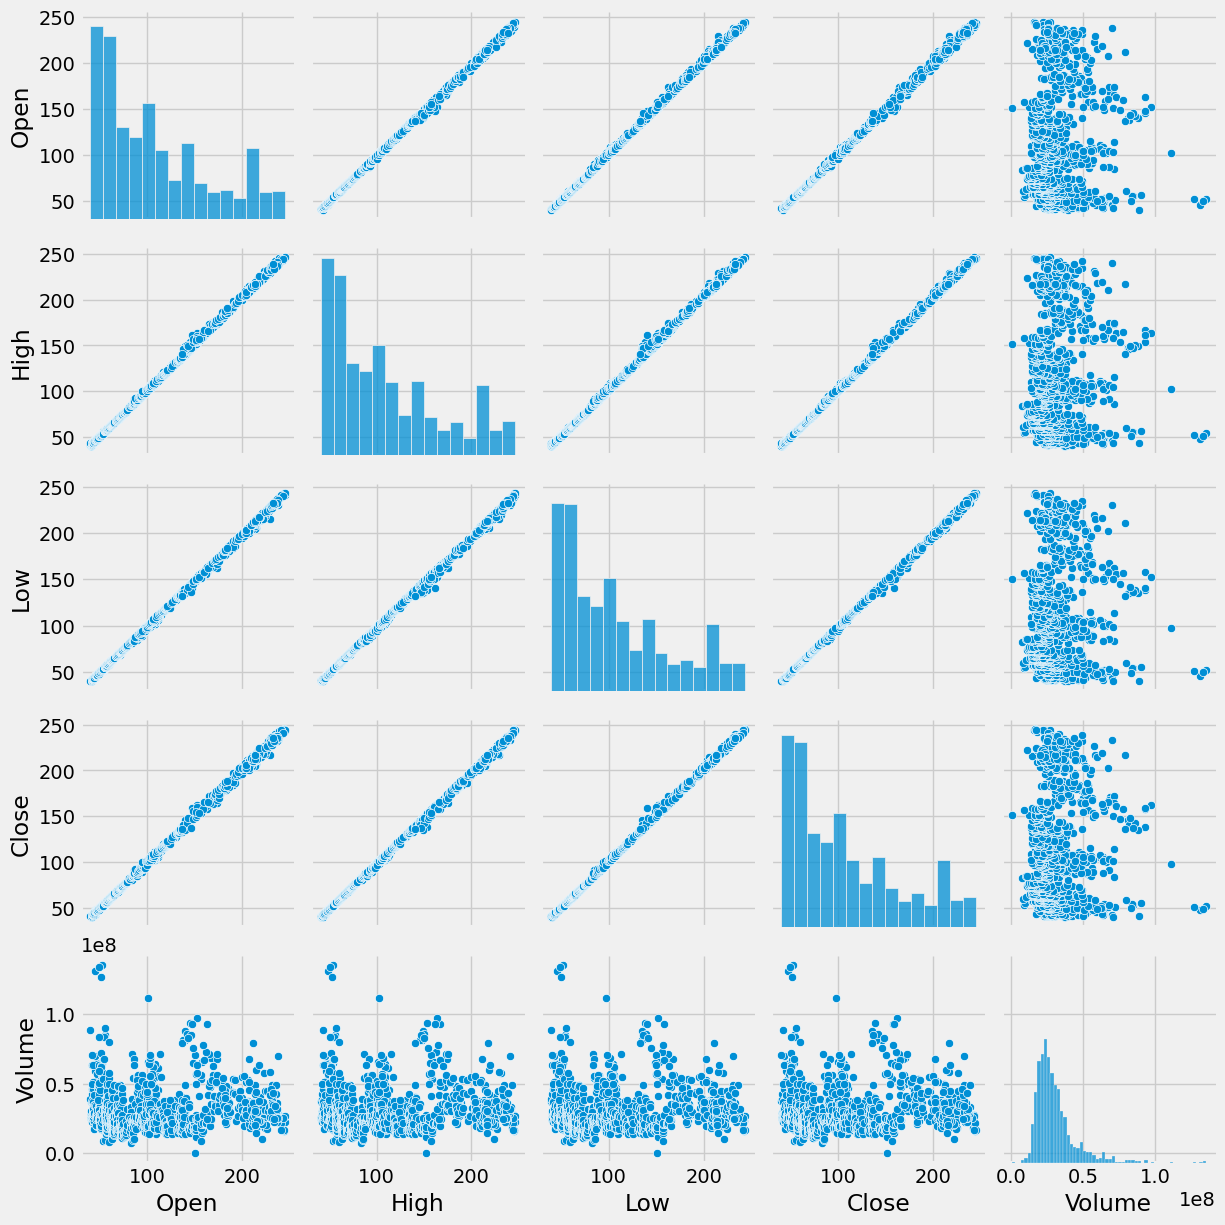

In [ ]:
import seaborn as sns
sns.pairplot(data=Jack_TS_Monthly_df)

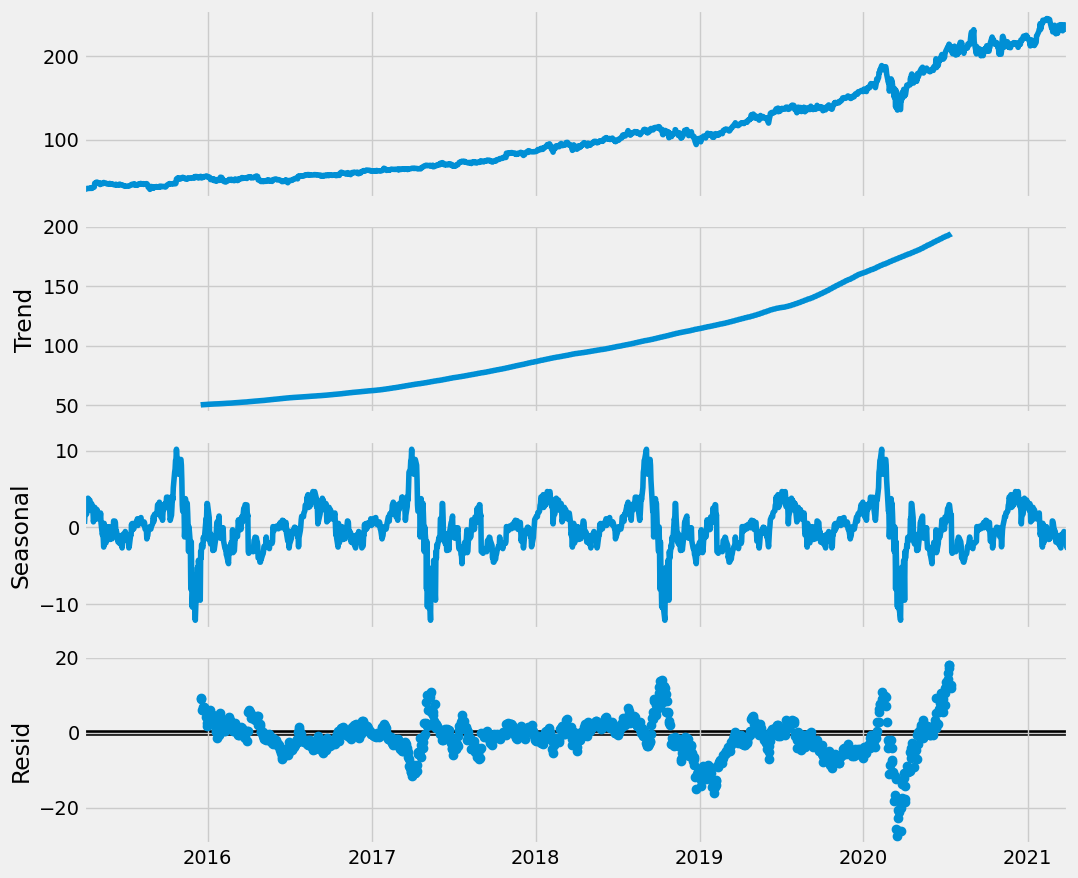

In [ ]:
rcParams['figure.figsize'] = 11, 9
Jack_pred_df_sim1_new = sm.tsa.seasonal_decompose(Jack_TS_Monthly_df[['Close']],model='additive',period=360) # The frequncy is annual

Jack_pred_df_sim2_full = Jack_TS_Monthly_df[['Close']]
figure = Jack_pred_df_sim1_new.plot()
plt.show()

In [ ]:
sim1=Jack_pred_df_sim1_new.resid.dropna()
sim2 = Jack_pred_df_sim2_full.dropna()
#sim2


#Part3: Now Let's try model

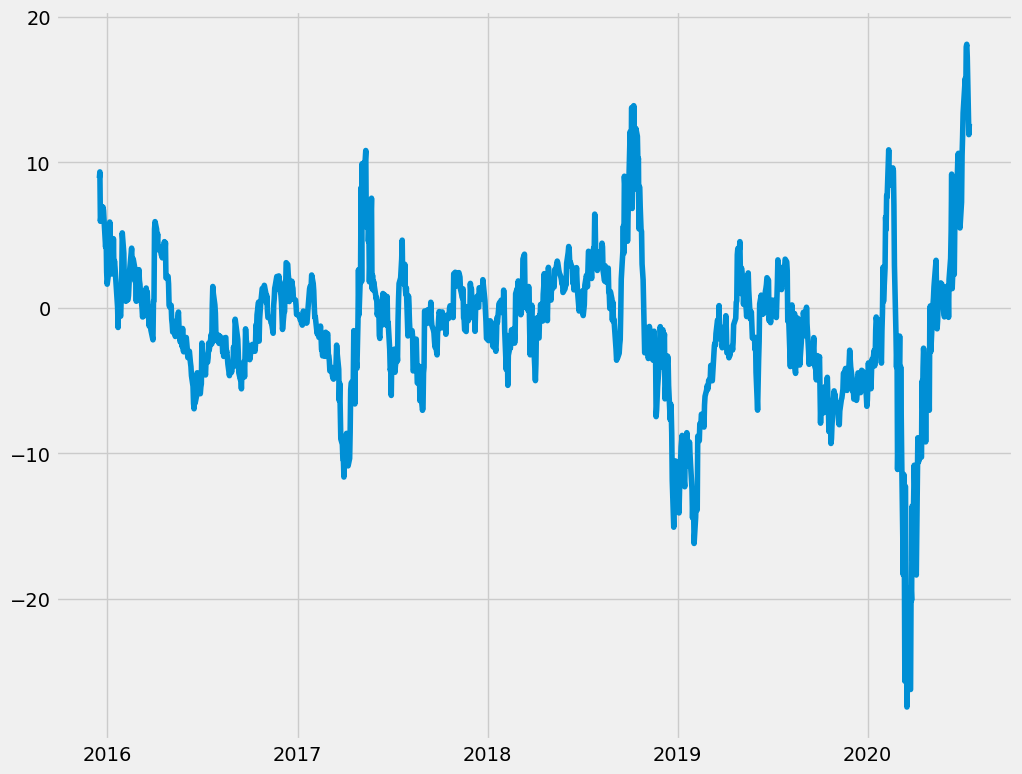

In [ ]:
plt.plot(sim1)

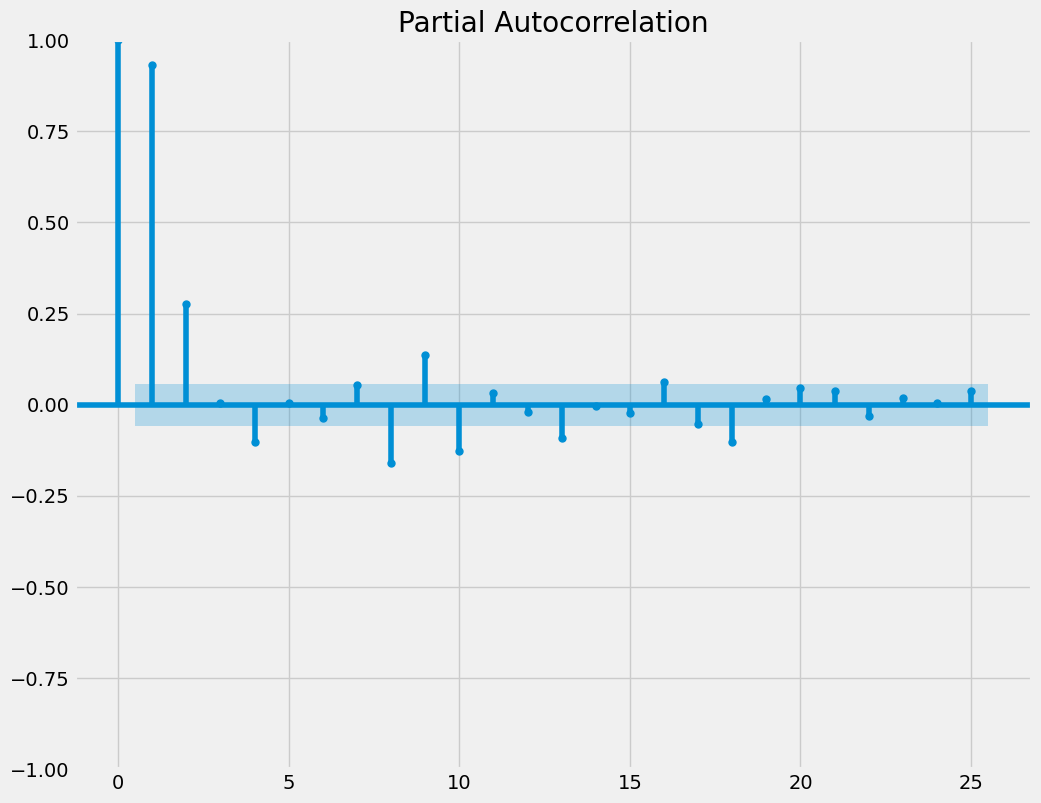

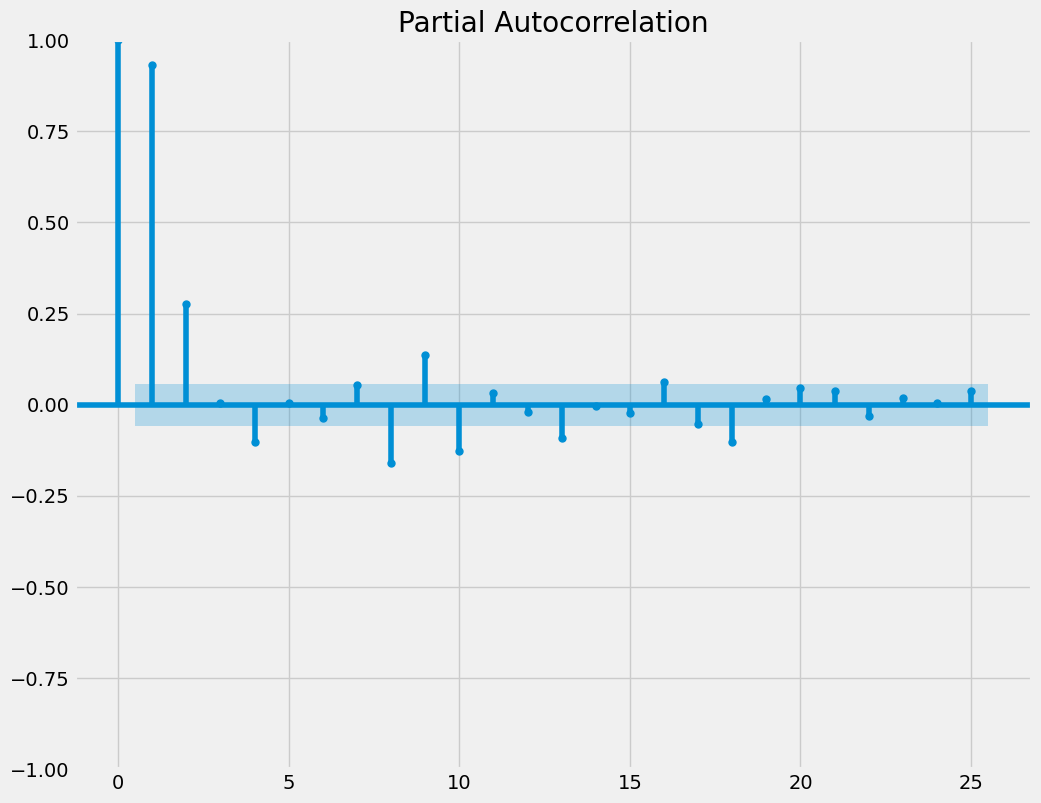

In [ ]:
plot_pacf(sim1, lags=25)

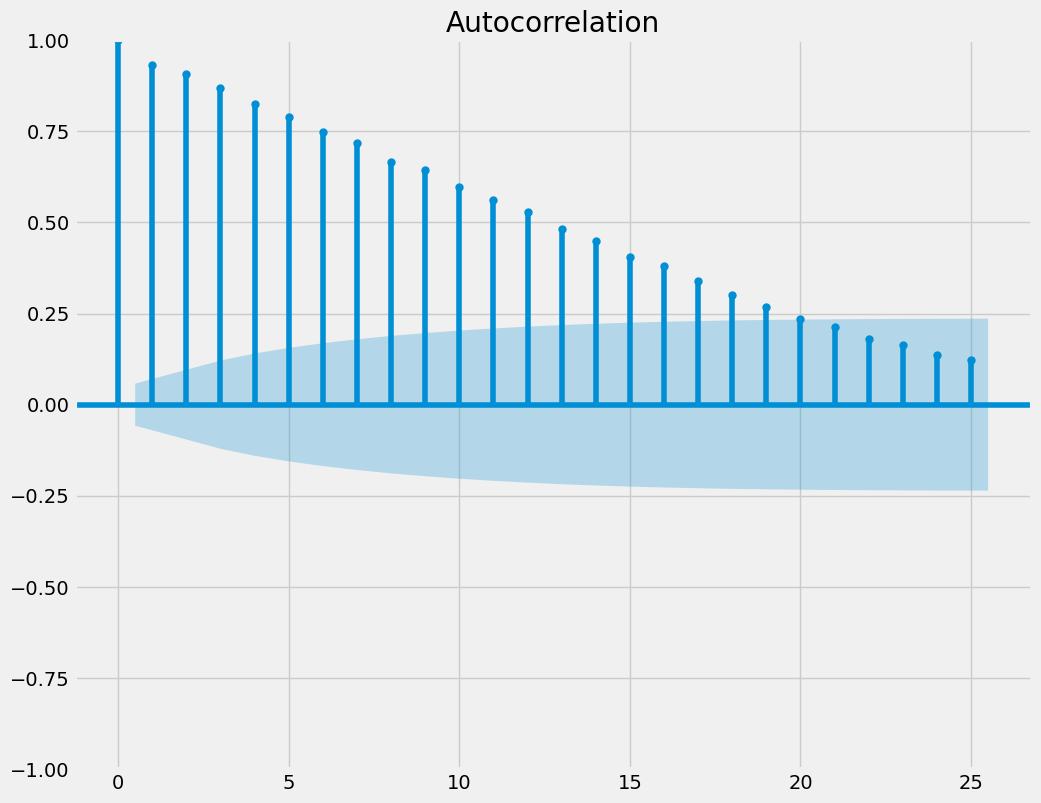

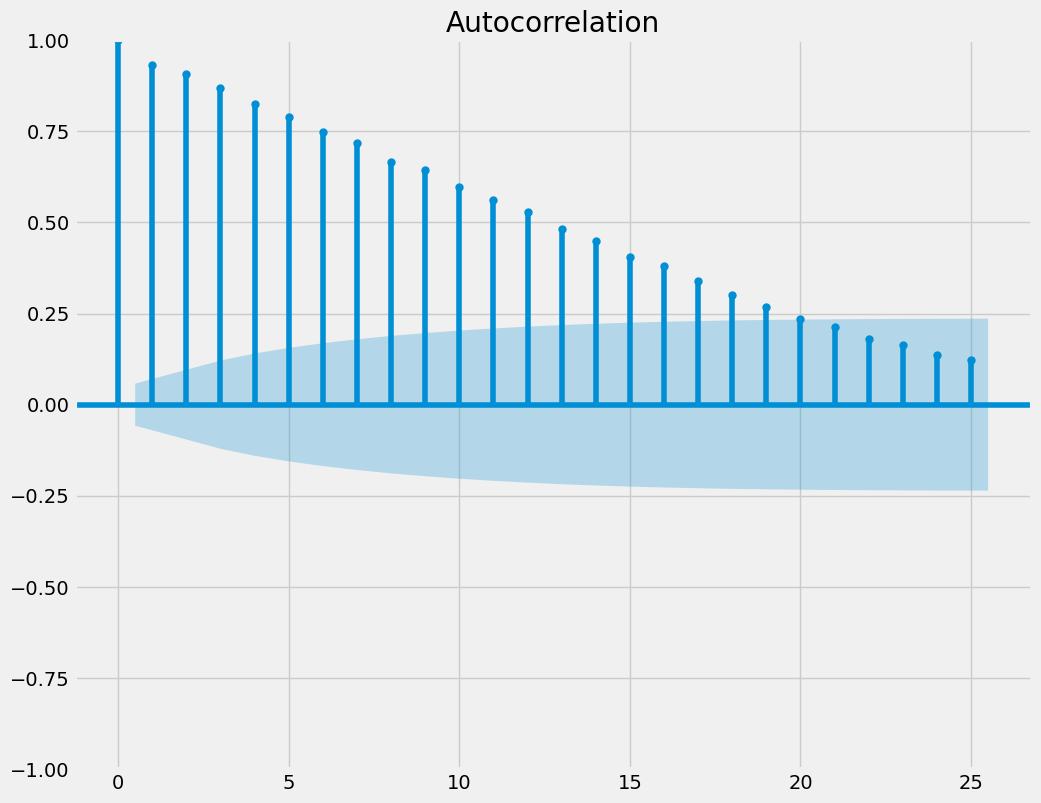

In [ ]:
plot_acf(sim1, lags=25)

In [ ]:
import statsmodels.tsa.arima.model as ArimaModel
#statsmodels.tsa.arima.model.ARIMA

model = ArimaModel.ARIMA(sim1, order=(2,1,0))
result = model.fit()


In [ ]:
# Predicting simulated AR(23) model
result.predict(start=1000, end=1200)
plt.show()

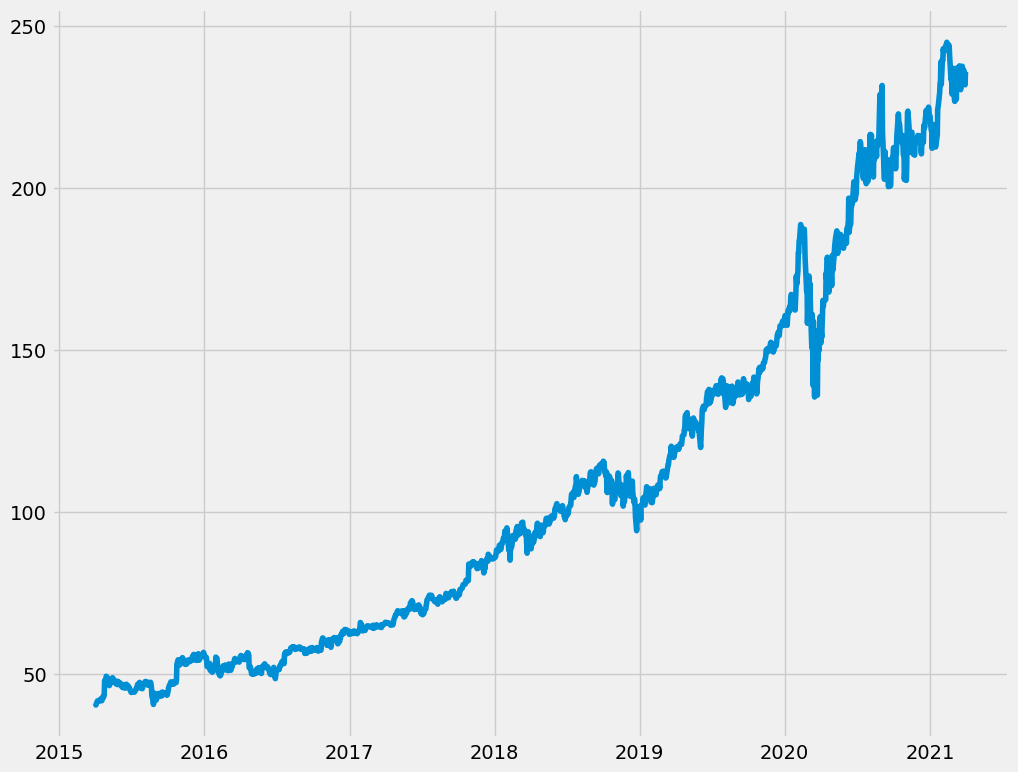

In [ ]:
plt.plot(sim2)

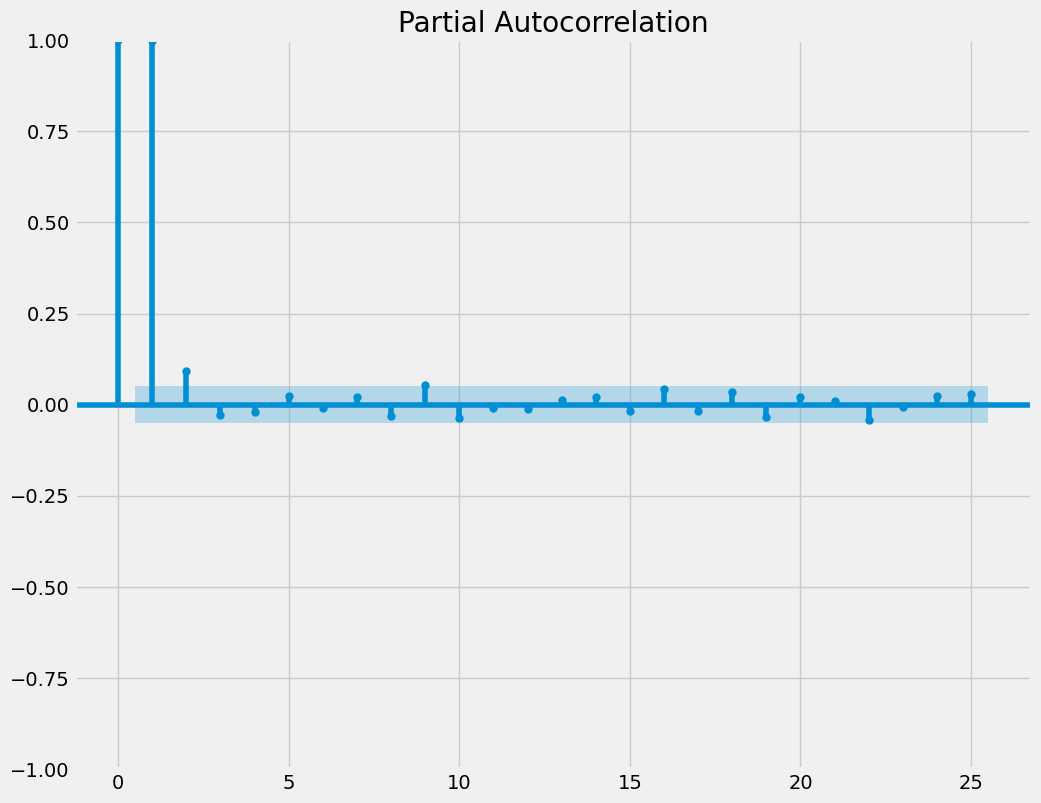

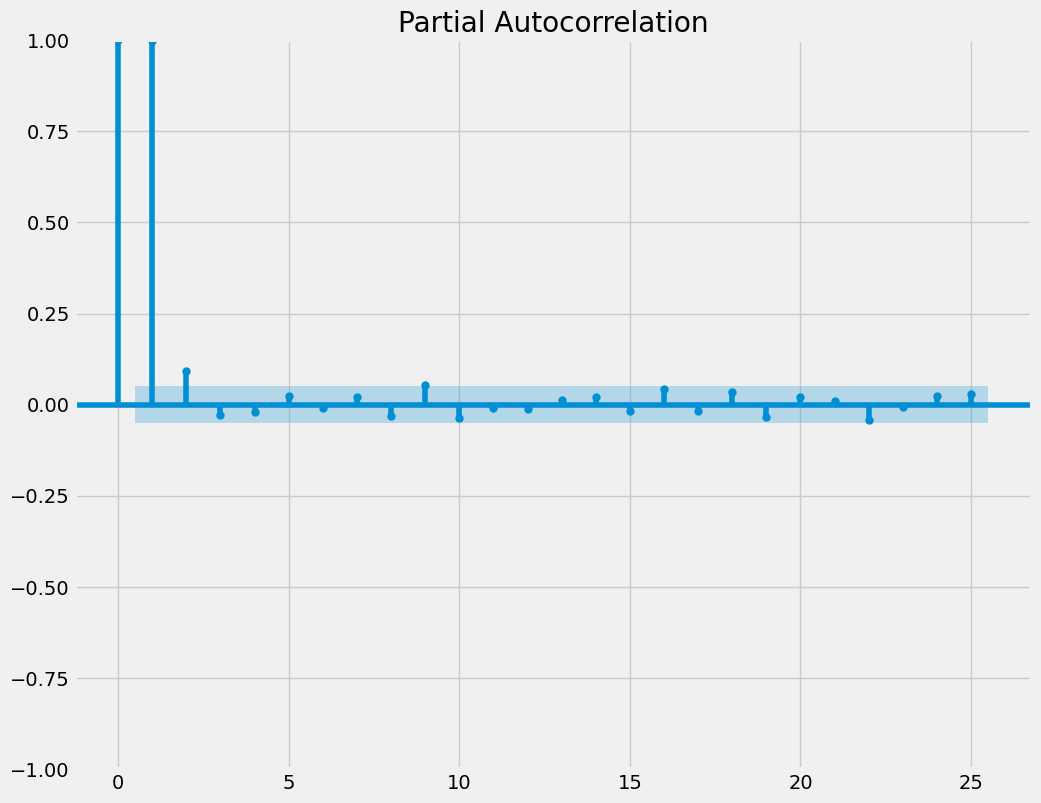

In [ ]:
plot_pacf(sim2, lags=25)

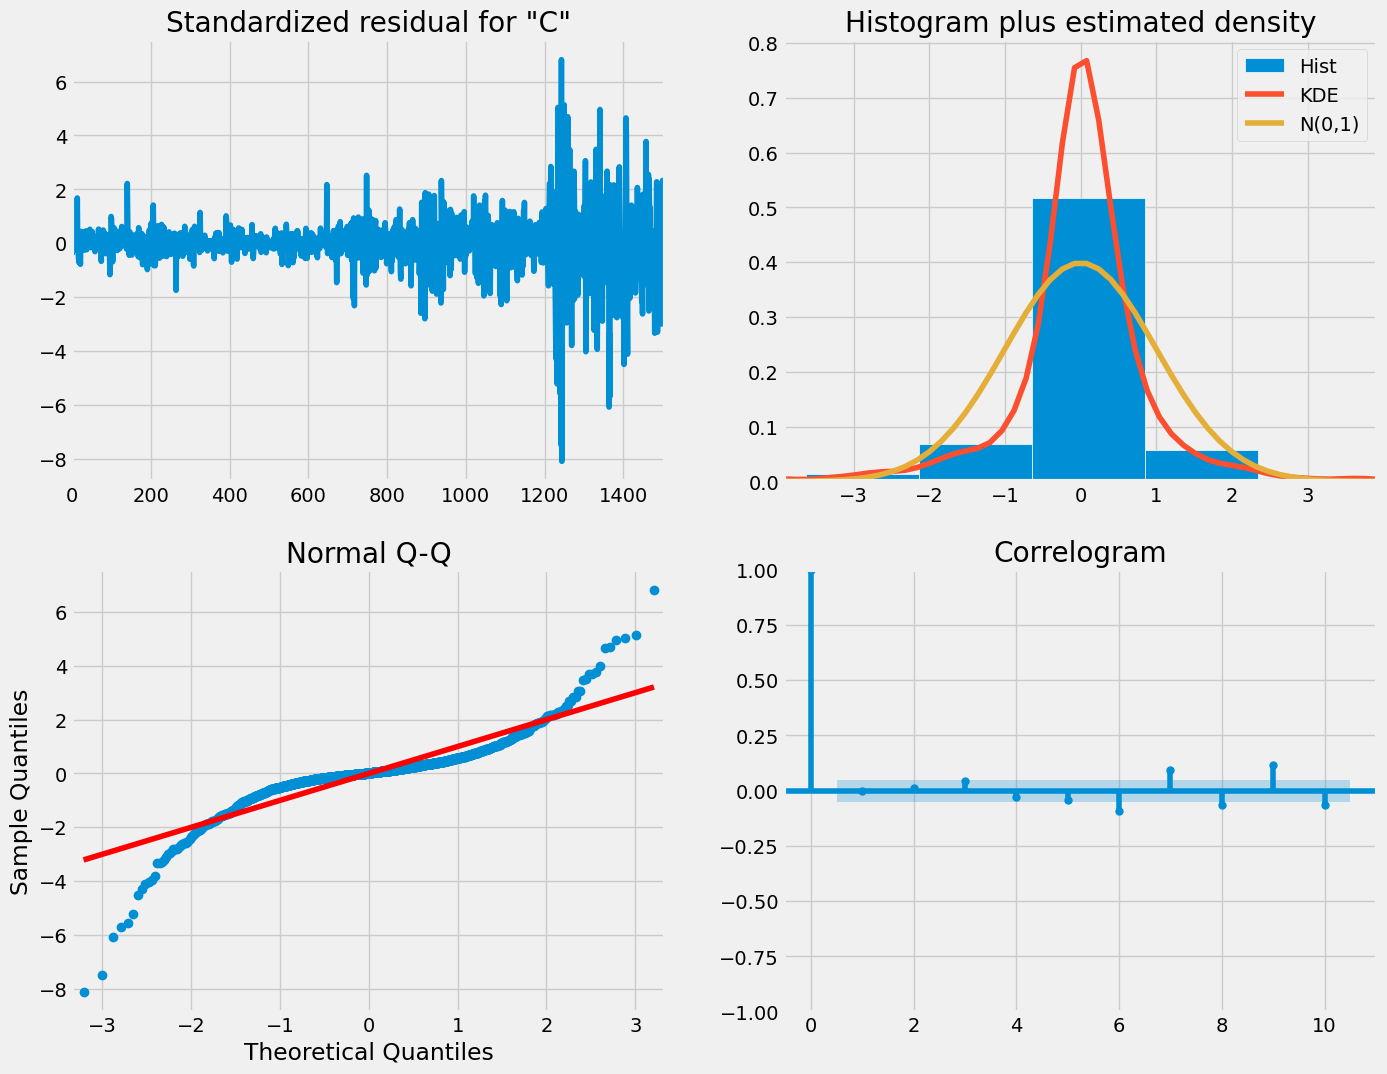

In [ ]:
mod = sm.tsa.statespace.SARIMAX(sim2,
                                order=(2, 3, 2),
				)

MSFTresults = mod.fit()
MSFTresults.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred = MSFTresults.get_prediction(start=1400, dynamic=False)

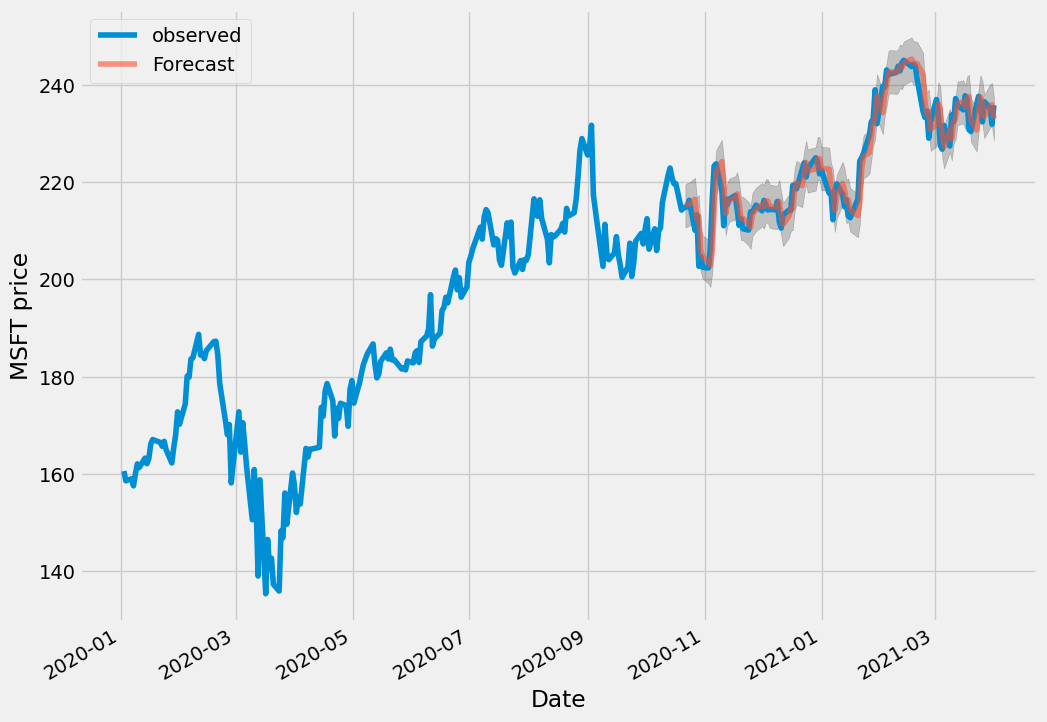

In [ ]:
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters.

ax = sim2['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT price')
plt.legend()

plt.show()


In [ ]:
pred_ci

,lower Close,upper Close
dateN,,
2020-10-21 16:00:00,210.612418,219.514021
2020-10-22 16:00:00,209.997024,221.023360
2020-10-23 16:00:00,209.357189,222.536967
2020-10-26 16:00:00,208.916362,223.855669
2020-10-27 16:00:00,208.551339,225.095641
...,...,...
2021-03-25 16:00:00,208.674942,307.157139
2021-03-26 16:00:00,208.596273,307.971977
2021-03-29 16:00:00,208.513974,308.789093


In [ ]:
forecast = pred.predicted_mean
forecast

dateN
2020-10-21 16:00:00    215.063219
2020-10-22 16:00:00    215.317779
2020-10-23 16:00:00    215.420882
2020-10-26 16:00:00    216.422521
2020-10-27 16:00:00    212.295177
                          ...    
2021-03-25 16:00:00    236.318551
2021-03-26 16:00:00    233.440364
2021-03-29 16:00:00    235.610308
2021-03-30 16:00:00    235.861549
2021-03-31 16:00:00    233.016192
Name: predicted_mean, Length: 111, dtype: float64

In [ ]:
sim2 = sim2.squeeze()

In [ ]:
truth = sim2['2020-10-21':]
truth

dateN
2020-10-21 16:00:00    214.80
2020-10-22 16:00:00    214.89
2020-10-23 16:00:00    216.23
2020-10-26 16:00:00    210.08
2020-10-27 16:00:00    213.25
                        ...  
2021-03-25 16:00:00    232.34
2021-03-26 16:00:00    236.48
2021-03-29 16:00:00    235.24
2021-03-30 16:00:00    231.85
2021-03-31 16:00:00    235.77
Name: Close, Length: 111, dtype: float64

In [ ]:
forecast = pred.predicted_mean
truth = sim2['2020-10-21':]
mse = ((forecast - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 12.82


In [ ]:
pred = MSFTresults.get_prediction(start=1400, dynamic=True)

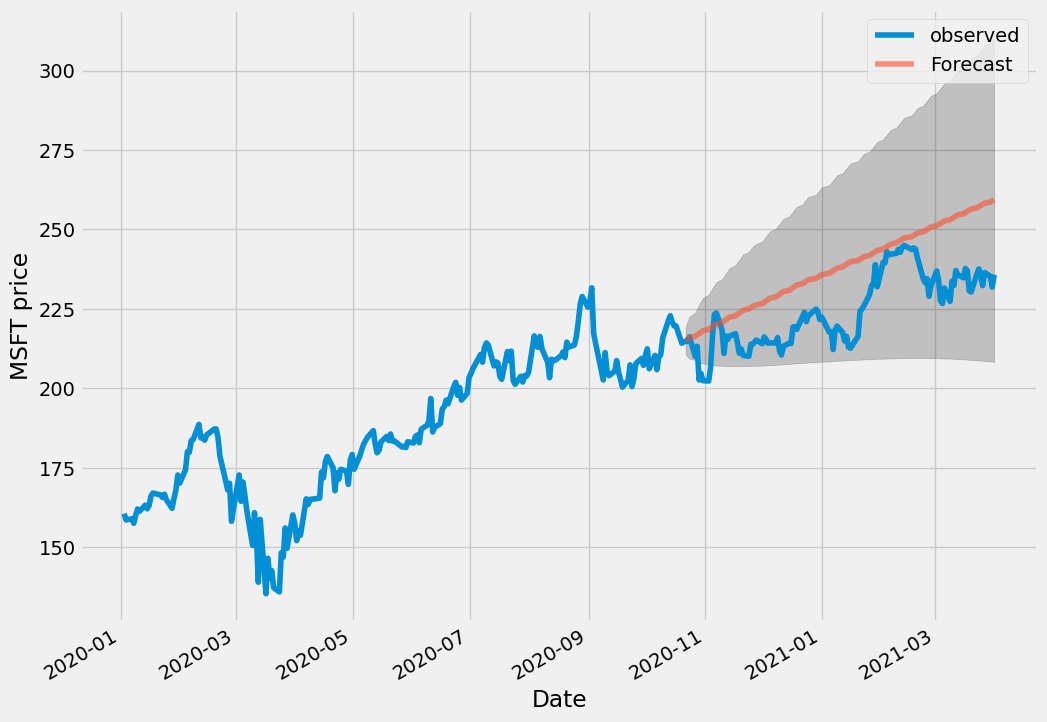

In [ ]:
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters.

ax = sim2['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT price')
plt.legend()
plt.show()
